# The Quantum Approximate Optimization Algorithm for MAX-CUT

---

2018/6/6:7 –– WNixalo. Code along of [QAOA_overview_maxcut.ipynb](https://github.com/rigetticomputing/grove/blob/master/grove/pyqaoa/getting-started/QAOA_overview_maxcut.ipynb)

> *I have no idea what I'm doing*

The following is a step-by-step guide to running QAOA on the MacCut problem. In the debut paper on QAOA (arXiv: 1411.4028), Farhi, Goldstone, and Gutmann demonstrate that the lowest order approximation of the algorithm produced an approximation ratio of **0.6946** for the MaxCut problem on 3-regular graphs. You can use this notebook to set up an arbitrary graph for MaxCut and solve it using the QAOA algorithm via the Rigetti Forest service.

`pyQAOA` is a python library that implements the QAOA. It uses the `PauliTerm` and `PauliSum` objects from the pyQuil library for expressing the cost and driver Hamiltonians. These operators are used to create a parametric pyQuil program and passed to the variational quantum eigensolver (VQE) in Grove. VQE calls the Rigetti Forest QVM to execute the Quil program that prepares the angle parameterized state. There're muliple ways to construct the MAX-CUT problem for the QAOA library. We include a method that accepts a graph and returns a QAOA instance where the costs and driver Hamiltonians have been constructed. The graph is either an undirected NetworkX graph or a list of tuples where each tuple represents an edge between a pair of nodes.

We start by demonstrating the QAOA algorithm with the simplest instance of MAXX-CUT –– partitioning the nodes on a barbell graph. The barbell graph corresponds to a single edge connecting 2 nodes. The solution is a partitioning of the nodes into different sets $\{0, 1\}$.

In [8]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
from functools import reduce

In [2]:
barbell = [(0,1)] # graph is defined by a list of edges. Edge weights are assumed to be 1.0
steps   = 1 # evolution path length ebtween the ref and cost hamiltonians
inst    = maxcut_qaoa(barbell, steps=steps) # initializing problem instance

The cost and driver Hamiltonians corresponding to the barbell graph are stored in QAOA object fields in the form of lists of PauliSums.

In [9]:
cost_list, ref_list = inst.cost_ham, inst.ref_ham
cost_ham = reduce(lambda x,y: x + y, cost_list)
ref_ham  = reduce(lambda x,y: x + y, ref_list)

print(cost_ham)
print(ref_ham)

(-0.5+0j)*I + (0.5+0j)*Z0*Z1
(-1+0j)*X0 + (-1+0j)*X1


The identity term above is not necessary to the computation since global phase rotations on the wavefunction don't change the expectation value. We include it here purely as a demonstration. The cost function printed above is the **negative** of the traditional Max Cut operator. This is *because QAOA is forumulated as the maximizaiton of the cost operator but the VQE algorithm in the pyQuil library performs a minimization.*

QAOA requires the construction of a state parameterized by β and γ rotation angles:

<img src="https://render.githubusercontent.com/render/math?math=%5Cbegin%7Balign%7D%0A%5Cmid%20%5Cbeta%2C%20%5Cgamma%20%5Crangle%20%3D%20%5Cprod_%7Bp%3D0%7D%5E%7B%5Cmathrm%7Bsteps%7D%7D%5Cleft%28%20U%28%5Chat%7BH%7D_%7B%5Cmathrm%7Bdrive%7D%7D%2C%20%5Cbeta_%7Bp%7D%29U%28%5Chat%7BH%7D_%7B%5Cmathrm%7BMAXCUT%7D%7D%2C%20%5Cgamma_%7Bp%7D%29%20%5Cright%29%5E%7B%5Cmathrm%7Bsteps%7D%7D%20%28%5Cmid%20%2B%5Crangle_%7BN-1%7D%5Cotimes%5Cmid%20%2B%20%5Crangle_%7BN-2%7D...%5Cotimes%5Cmid%20%2B%20%5Crangle_%7B0%7D%29.%0A%5Cend%7Balign%7D&mode=display">

The unitaries <img src="https://render.githubusercontent.com/render/math?math=U%28%5Chat%7BH%7D_%7B%5Cmathrm%7Bdrive%7D%7D%2C%20%5Cbeta_%7Bp%7D%29&mode=inline" style='display:inline; margin-top:0px;'> and <img src="https://render.githubusercontent.com/render/math?math=U%28%5Chat%7BH%7D_%7B%5Cmathrm%7BMAXCUT%7D%7D%2C%20%5Cgamma_%7Bp%7D%29&mode=inline" style='display:inline; margin-top:0px;'> are exponentiations of the driver and cost Hamiltonians, respectively.

<img src="https://render.githubusercontent.com/render/math?math=%5Cbegin%7Balign%7D%0AU%28%5Chat%7BH%7D_%7B%5Cmathrm%7Bref%7D%7D%2C%20%5Cbeta_%7Bp%7D%29%20%3D%20e%5E%7B-i%20%5Cbeta_%7Bp%7D%20%5Chat%7BH%7D_%7Bdrive%7D%7D%20%5C%5C%0AU%28%5Chat%7BH%7D_%7B%5Cmathrm%7BMAXCUT%7D%7D%2C%20%5Cgamma_%7Bp%7D%29%20%3D%20e%5E%7B-i%20%5Cgamma_%7Bp%7D%20%5Chat%7BH%7D_%7B%5Cmathrm%7BMAXCUT%7D%7D%7D%0A%5Cend%7Balign%7D&mode=display">

The QAOA algorithm relies on many constructions of a wavefunction via parameterized Quil and measurements on all qubits to evaluate an expectation value. In order to avoid needless classical computation, QAOA constructions this parametric program once at the beginning of the calculation and then uses this same program object throughout the computation. This is accomplished using the `ParametricProgram` object pyQuil that allows us to slot in a symbolic value for a parameterized gate.

The parameterized program object can be accessed through the `QAOA` method `get_parameterized_program()`. Calling this on an instantiated `QAOA` object returns a closure with a precomputed set of Quil Programs (*wtf does that mean*). Calling this closure with the parameters β and γ returns the circuit that has parameterized rotations (*what*).

In [10]:
param_prog = inst.get_parameterized_program()
prog = param_prog([1.2, 4.2])
print(prog)

H 0
H 1
X 0
PHASE(2.1) 0
X 0
PHASE(2.1) 0
CNOT 0 1
RZ(4.2) 1
CNOT 0 1
H 0
RZ(-2.4) 0
H 0
H 1
RZ(-2.4) 1
H 1



The above printout is a Quil program that can be executed on a QVM. QAOA has 2 methods of operation:
1. pre-computing the angles of rotation classically and using the quantum computer to measure expectation values through repeated experiments and,
2. installing a classical optimization loop on top of step 1 to optimally determine the angles.

Mode 2 is known as the Variational Quantum Eigensolver Algorith. The `QAOA` object wraps the instantiation of the VQE alorithm with a`get_angles()`.

In [11]:
betas, gammas = inst.get_angles()
print(betas, gammas)

                     models will be ineffective
	Parameters: [1.53757773 2.11959256] 
	E => -0.44348554404104473
	Parameters: [1.69848703 1.99636043] 
	E => -0.722620492101773
	Parameters: [1.85045692 2.23050147] 
	E => -0.8553835038130927
	Parameters: [2.01136622 2.10726934] 
	E => -0.6804871082868924
	Parameters: [2.01136622 2.10726934] 
	E => -0.8659402038807896
	Parameters: [2.01136622 2.10726934] 
	E => -0.9007195204740152
	Parameters: [1.90409335 2.05797649] 
	E => -0.9007120680626116
	Parameters: [1.99348741 1.83615867] 
	E => -0.9790307930139265
	Parameters: [1.99348741 1.83615867] 
	E => -0.9652252026224843
	Parameters: [1.97560859 1.56504799] 
	E => -0.9753319584929054
	Parameters: [1.97560859 1.56504799] 
	E => -0.9894305290521704
	Parameters: [1.97560859 1.56504799] 
	E => -0.9970743378376596
	Parameters: [1.97560859 1.56504799] 
	E => -0.9976525641970495
	Parameters: [1.95374895 1.54165314] 
	E => -0.9994079197334041
	Parameters: [1.96382325 1.59275115] 
	E => -0.999879071

`get_angles()` returns optimal β and γ angles. To view the probs of the state, you can call `QAOA.probabilities(t)` where `t` is a concatenation of β and γ, in that order. `probabilities(t)` takes β & γ, reconstructs the wave function, and returns their coefficients. A modified version can be used to print off the probabilities:

In [16]:
param_prog = inst.get_parameterized_program()
t = np.hstack((betas, gammas))
prog = param_prog(t)
wf = inst.qvm.wavefunction(prog)
wf = wf.amplitudes

for i in range(2**inst.n_qubits):
    print(inst.states[i], np.conj(wf[i])*wf[i])

00 (6.498614830805159e-07+0j)
01 (0.4999993501385163+0j)
10 (0.4999993501385163+0j)
11 (6.498614830805159e-07+0j)


As expected the bipartitioning of a graph with a single edge connecting 2 nodes corresponds to the state $\{ \rvert 01 \rangle, \rvert 10 \rangle \}$

> *oh... cool it actually does. Great, so far so good.*

In this trivial example the QAOA finds angles that constuct a distribution peaked around the 2 degenerate solutions.

## MAXCUT on larger graphs and alternative optimizers

Larger graph instances and different classical optimizers can be used with the QAOA. Here we consider a 6-node ring of disagrees (*eh?*). For an even number ring graph, the ring of disagrees corresponds to the antiferromagnet ground state –– ie: alternating spin-up spin-down.

> *do we have to analogize everything to a physical QM phenom or is that just narrative-momentum?*

In [17]:
%matplotlib inline

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

from grove.pyqaoa.qaoa import QAOA
import pyquil.quil as pq
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.gates import H
from pyquil.api import QVMConnection

In [19]:
# wonder why they call it "CXN". pyQuil docs called it "quantum_simulator"
CXN = QVMConnection() # heh, CXN --> "connection"?

In [20]:
# define 6-qubit ring
ring_size = 6
graph = nx.Graph()
for i in range(ring_size):
    graph.add_edge(i, (i + 1) % ring_size)

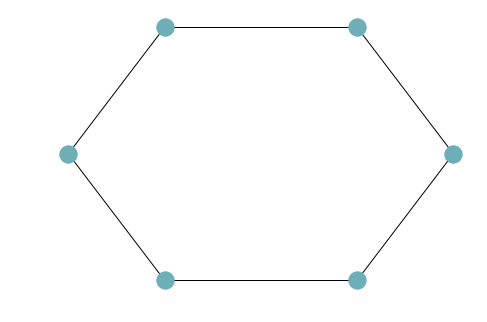

In [24]:
nx.draw_circular(graph, node_color="#6CAFB7")

This graph could be passed to the `maxcut_qaoa` method, and a `QAOA` instance with the correct driver & cost Hamiltonian could be generated as before. In order to demonstrate the more general approach, along with some VQE options, we'll construct the cost and driver Hamiltonians directly with `PauliSum` and `PauliTerm` objects. To do this we parse the edges and nodes of the graph to construct the relevant operators:

<img src="https://render.githubusercontent.com/render/math?math=%5Cbegin%7Balign%7D%0A%5Chat%7BH%7D_%7B%5Cmathrm%7Bcost%7D%7D%20%3D%20%5Csum_%7B%5Clangle%20i%2C%20j%5Crangle%20%5Cin%20E%7D%5Cfrac%7B%5Csigma_%7Bi%7D%5E%7Bz%7D%5Csigma_%7Bj%7D%5E%7Bz%7D%20-%201%7D%7B2%7D%20%5C%5C%0A%5Chat%7BH%7D_%7B%5Cmathrm%7Bdrive%7D%7D%20%3D%20%5Csum_%7Bi%7D%5E%7Bn%7D-%5Csigma_%7Bi%7D%5E%7Bx%7D%0A%5Cend%7Balign%7D&mode=display">

where $\langle i, j \rangle \in E$ referes to the pairs of nodes that form the edges of the graph.

In [27]:
cost_operators   = []
driver_operators = []
for i,j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, 0.5) *
                          PauliTerm("Z", j)      +
                          PauliTerm("I", 0, -0.5))
for i in graph.nodes():
    driver_operators.append(PauliSum([PauliTerm("X", i, 1.0)]))

We'll also construct the initial state and pass this to the QAOA object. By default, `QAOA` uses the $\rvert + \rangle$ tensor product state. In other notebooks we'll demonstrate that you can use the `driver_ref` optional argument to pass a different starting state for QAOA.

In [33]:
prog = pq.Program()
for i in graph.nodes():
    prog.inst(H(i))

We're now ready to instantuate the QAOA object! 🎉

In [36]:
ring_cut_inst = QAOA(CXN, len(graph.nodes()), steps=1, ref_hamiltonian=driver_operators,
                     cost_ham=cost_operators, driver_ref=prog, store_basis=True,
                     rand_seed=42)

In [37]:
betas, gammas = ring_cut_inst.get_angles()

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -4.499978
         Iterations: 16
         Function evaluations: 31


We're interested in the bit strings returned from the QAOA algorithm. The `get_angles()` routine calls the VQE algorithm to find the best angles. We can then manually query the bit strings by rerunning the program and sampling many outputs.

In [76]:
from collections import Counter

# get the parameterized program
param_prog = ring_cut_inst.get_parameterized_program()
sampling_prog = param_prog(np.hstack((betas, gammas)))

# use the run_and)measure QVM API to prepare a circuit and then measure on the qubits
bitstring_samples = CXN.run_and_measure(quil_program=sampling_prog, qubits=range(len(graph.nodes())), trials=1000)
bitstring_tuples = map(tuple, bitstring_samples)

# aggregate the statistics
freq = Counter(bitstring_tuples)
most_frequent_bit_string = max(freq, key=lambda x: freq[x])

print(freq) ##for f in freq.items(): (print(f"{f[0]}, {f[1]}"))
print(f"The most frequently sampled string is {most_frequent_bit_string}")

Counter({(0, 1, 0, 1, 0, 1): 169, (1, 0, 1, 0, 1, 0): 130, (0, 1, 0, 0, 1, 1): 41, (0, 0, 1, 1, 0, 1): 40, (1, 0, 0, 1, 0, 1): 37, (1, 1, 0, 1, 1, 0): 36, (0, 1, 0, 0, 1, 0): 34, (0, 0, 1, 0, 1, 1): 33, (1, 1, 0, 1, 0, 0): 33, (0, 1, 1, 0, 0, 1): 33, (1, 0, 0, 1, 1, 0): 32, (1, 1, 0, 0, 1, 0): 30, (0, 0, 1, 0, 0, 1): 30, (0, 1, 0, 1, 1, 0): 29, (0, 1, 1, 0, 1, 0): 29, (1, 0, 0, 1, 0, 0): 29, (0, 1, 1, 0, 1, 1): 28, (1, 0, 1, 1, 0, 1): 27, (1, 0, 1, 1, 0, 0): 26, (1, 0, 1, 0, 0, 1): 25, (0, 1, 0, 0, 0, 1): 12, (0, 1, 0, 1, 0, 0): 10, (0, 0, 1, 0, 1, 0): 10, (0, 0, 0, 1, 0, 1): 9, (1, 0, 1, 0, 0, 0): 8, (1, 0, 0, 0, 1, 0): 8, (0, 1, 0, 1, 1, 1): 7, (1, 1, 0, 1, 0, 1): 7, (0, 0, 1, 1, 1, 0): 6, (0, 1, 1, 1, 0, 1): 6, (1, 0, 1, 0, 1, 1): 6, (1, 1, 1, 0, 1, 0): 5, (1, 0, 1, 1, 1, 1): 5, (1, 1, 1, 0, 0, 0): 4, (1, 0, 1, 1, 1, 0): 3, (1, 1, 1, 1, 1, 0): 3, (0, 0, 0, 0, 1, 0): 3, (1, 0, 0, 0, 0, 0): 3, (0, 0, 0, 1, 1, 1): 3, (0, 1, 1, 1, 0, 0): 2, (1, 1, 0, 0, 0, 1): 2, (1, 0, 0, 0, 1, 1): 2, 

We can see that the first 2 most frequently sampled strings are the alternating solutions to the ring graph (*well damn, they are*). Since we have to access the wave function, we can go one step further and view the probability distribution over the bit strings produced by our $p = 1$ circuit.

In [95]:
# plot strings!
n_qubits = len(graph.nodes())
def plot(inst, probs):
    probs = probs.real
    states = inst.states
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("state",fontsize=20)
    ax.set_ylabel("Probability",fontsize=20)
    ax.set_xlim([0, 2**n_qubits])
    rec = ax.bar(range(2**n_qubits), probs[:,0],)
    num_states = [0, 
                  int("".join(str(x) for x in [0,1] * (n_qubits//2)), 2),
                  int("".join(str(x) for x in [1,0] * (n_qubits//2)), 2),
                  2**n_qubits - 1]
    ax.set_xticks(num_states)
    ax.set_xticklabels(map(lambda x: inst.states[x], num_states), rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

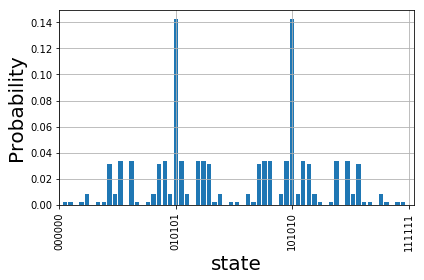

In [98]:
t = np.hstack((betas, gammas))
probs = ring_cut_inst.probabilities(t)
plot(ring_cut_inst, probs)

For larger graphcs the probability of sampling the correct string could be significantly smaller, though still peaked around the solution. Therewfore we'd want to increase the probability of sampling the solution relative to any other string. To do this we simply increase the number of steps $p$ in the algorithm. We might want to bootstrap the algorithm with angles from a lower number of steps. We can pass initial angles to the solver as optional arguments:

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -4.999986
         Iterations: 97
         Function evaluations: 162


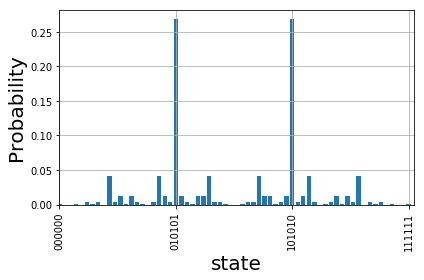

In [100]:
# get the angles from the last run
beta  = ring_cut_inst.betas
gamma = ring_cut_inst.gammas
# form new beta/gamma angles from the old angles
betas  = np.hstack((beta[0]/3, beta[0]*2/3))
gammas = np.hstack((gamma[0]/3, gamma[0]*2/3))
# set up a new QAOA instance
ring_cut_inst_2 = QAOA(CXN, len(graph.nodes()), steps=2, 
                       ref_hamiltonian=driver_operators, cost_ham=cost_operators,
                       driver_ref=prog, store_basis=True, 
                       init_betas=betas, init_gammas=gammas)
# run VQE to determine the optimal angles
betas, gammas = ring_cut_inst_2.get_angles()
t = np.hstack((betas, gammas))
probs = ring_cut_inst_2.probabilities(t)
plot(ring_cut_inst_2, probs)

We could also change the optimizer passed down to VQE via the QAOA interface. Let's say we want to use BFGS or another optimizer that can be wrapped in python. Simple pass it to `QAOA` via the `minimizer`, `minimizer_args`, and `minimizer_kwargs` keywords:

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -6.000000
         Iterations: 14
         Function evaluations: 160
         Gradient evaluations: 20


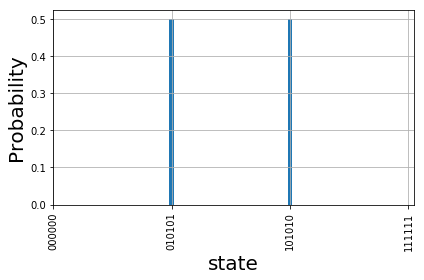

In [103]:
from scipy.optimize import fmin_bfgs

ring_cut_inst_3 = QAOA(CXN, len(graph.nodes()), steps=3,
                       ref_hamiltonian=driver_operators, cost_ham=cost_operators,
                       driver_ref=prog, store_basis=True,
                       minimizer=fmin_bfgs, minimizer_kwargs={'gtol':1.0e-3},
                       rand_seed=42)
betas,gammas = ring_cut_inst_3.get_angles()
t = np.hstack((betas, gammas))
probs = ring_cut_inst_3.probabilities(t)
plot(ring_cut_inst_3, probs)